# E2a: Küchentischversuch zum Laval-Rotor

Name:  Jannik Hoffmann
Datum:  04.01.2024

## Forschungsfrage

Ist es möglich mit einem günstigen Beschleunigungssensor die Vibration bzw Unwuchten an Gegenständen auszuwerten?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="image/Speaker.jpg" width="500">

- Beschreibung des Aufbaus: Ich habe den Beschleunigungssensor an meinem Bluetooth Lautsprecher mit einem Stück Klebeband angebracht, ich habe dabei eine Stelle gewählt die nicht leitfähig ist um den Sensor nicht kurzzuschließen.
- Vorgangsbeschreibung: Während der Messung spielte ich ein Techno Lied meiner Wahl ab.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [60]:
import h5py                                                                                      #importieren der benötigten Bibiotheken
import numpy as np                                                                               #importieren der benötigten Bibiotheken
import json                                                                                      #importieren der benötigten Bibiotheken
import os                                                                                        #importieren der benötigten Bibiotheken

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata                                               #importieren der benötigten Funktionen

from functions.m_postprocessing import get_vec_accel                                            #importieren der benötigten Funktionen (Wenn etwas in den Funktionen steht, Fehler "Funktion nicht definiert"
from functions.m_postprocessing import interpolation                                            #importieren der benötigten Funktionen (Wenn etwas in den Funktionen steht, Fehler "Funktion nicht definiert"
from functions.m_postprocessing import my_fft                                                   #importieren der benötigten Funktionen (Wenn etwas in den Funktionen steht, Fehler "Funktion nicht definiert"

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [61]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = '/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_154120_JannikHoffmann_Speaker'     #Pfad zum Ordner in dem die Messdaten abgelegt wurden
h5_file_name = 'data_20240109_154120_JannikHoffmann_Speaker.h5'                                                                  #Name der HDF5 Datei in dem die Messdaten abgelegt wurden
# ---------------------------------------------------------------------------------------------#1-end

In [62]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_154120_JannikHoffmann_Speaker/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_154120_JannikHoffmann_Speaker/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_154120_JannikHoffmann_Speaker/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeab001-7e77-6dce

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [63]:
datapath = path_measurement_folder + '/' + h5_file_name                                    #Vollständiger Pfad zur HDF5 Datei zusammensetzen aus dem Ordner Pfad und dem Namen der HDF5 Datei
with h5py.File(datapath) as l:                                                             #HDF5 öffnen als "l" 
    h5_datei = l["RawData"]
    list_x = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_x"]              #Liste anlegen für die Messwerte der Beschleunigungen in x-Richtung abzuspeichern
    list_y = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_y"]              #Liste anlegen für die Messwerte der Beschleunigungen in y-Richtung abzuspeichern
    list_z = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_z"]              #Liste anlegen für die Messwerte der Beschleunigungen in z-Richtung abzuspeichern
    list_time = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]                #Liste anlegen für die Zeitpunkte der Messungen abzuspeichern
    list_x_Array=np.array(list_x)                                                          #Aus Liste der Messwerte der Beschleunigungen in x-Richtung ein Array erzeugen
    list_y_Array=np.array(list_y)                                                          #Aus Liste der Messwerte der Beschleunigungen in y-Richtung ein Array erzeugen
    list_z_Array=np.array(list_z)                                                          #Aus Liste der Messwerte der Beschleunigungen in z-Richtung ein Array erzeugen
    list_time_Array=np.array(list_time)                                                    #Aus Liste der Zeitpunkte der Messungen ein Array erzeugen

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [64]:
absolutwerte = []                                                                         #Leere Liste erstellen um die Absolutwerte der Beschleunigungen abzuspeichern
i = 0                                                                                     #Index i als 0 definieren
while i < len(list_x_Array):                                                              #While Schleife ist erfüllt solange i kleiner ist als die Länge des Arrays mit den x-Beschleunigungswerten (Alle 3 Arrays sind gleich lang)
    b = list_x_Array[i]
    c = list_y_Array[i]
    d = list_z_Array[i]                                                                   #Die Einträge i aus den Arrays in den Variablen b,c,d abspeichern
    z = pow((pow(b,2)+ pow(c,2) + pow(d,2)),1/2)                                          #Betrag der Einträge i aus jedem Array bilden
    absolutwerte.append(z)                                                                #Beträge in der Leeren Liste hinzufügen
    i += 1                                                                                #Index bei jedem durchlauf der Schleife um 1+ nach oben zählen
absolutwerte_nparray = np.array(absolutwerte)                                             #Absolutwerte aus der Liste in ein Absolutwerte Array überführen

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'Zeitlichen Abstände zwischen den Messpunkten in s')

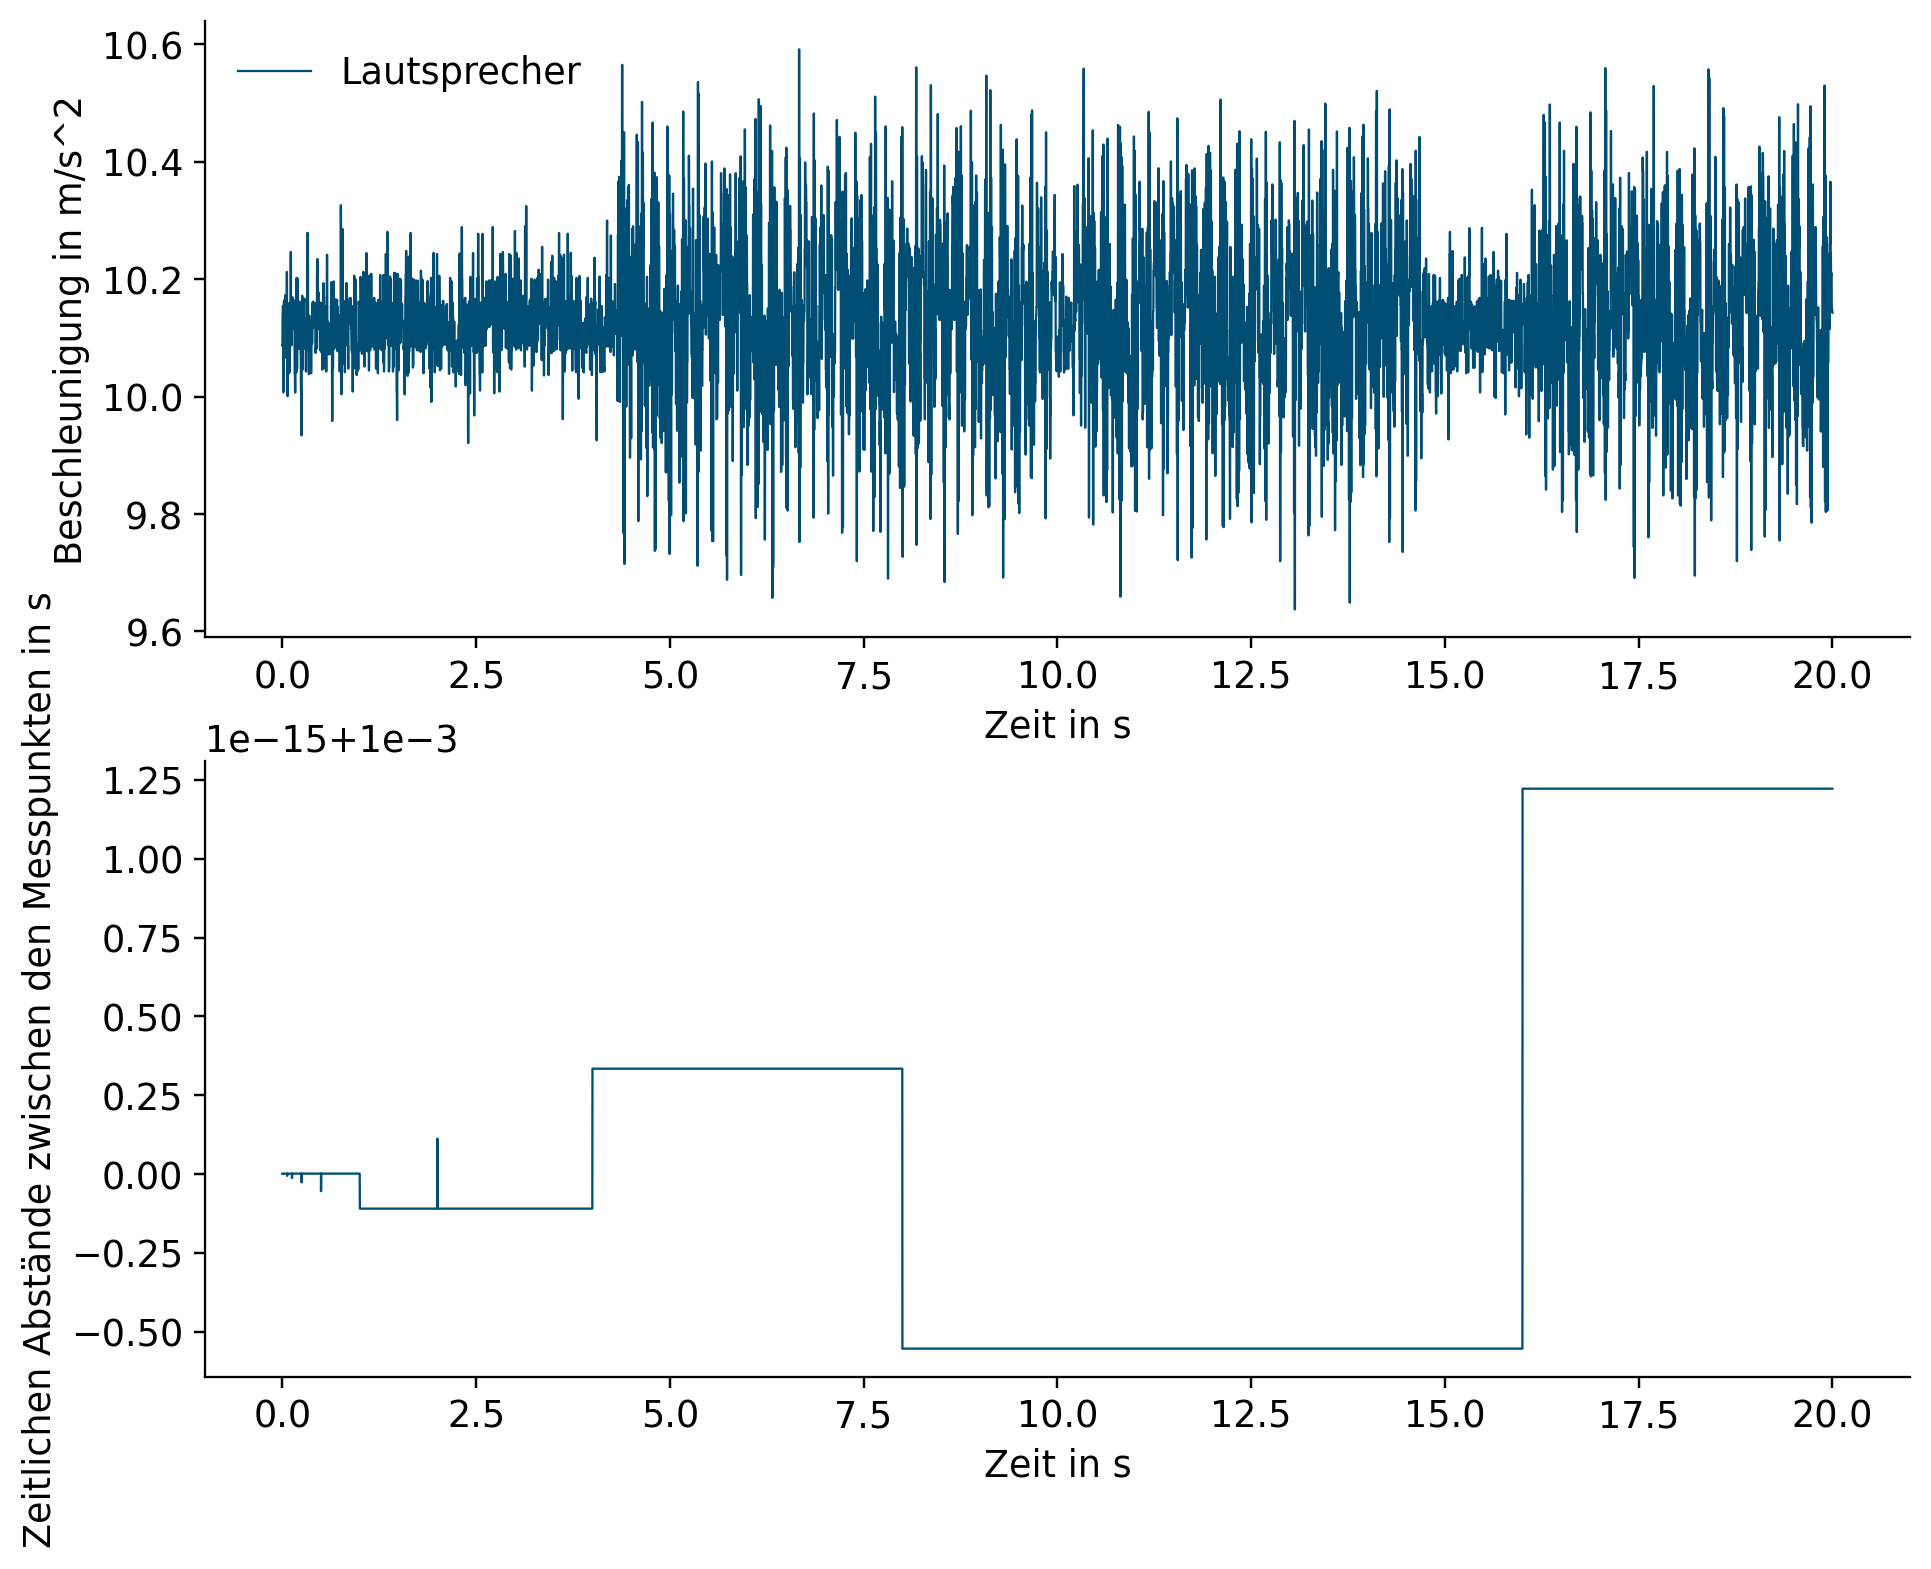

In [65]:
fig, (ax1, ax2)= plt.subplots(2,1,figsize=(10,8 ))
 
ax1.plot(list_time_Array, absolutwerte_nparray, label = 'Lautsprecher')                   #Array mit den Absolutwerten der Beschleunigung und den Zeiteinträgen plotten
ax1.set_xlabel('Zeit in s')                                                               #x-Achse beschriften
ax1.set_ylabel('Beschleunigung in m/s^2')                                                 #y-Achse beschriften
ax1.legend()                                                                              #Legende anzeigen lassen



time_intervall = np.diff(list_time_Array)                                                 #Array erstellen mit den Abständen der aufeinander folgenden Zeiteinträge
ax2.plot(list_time_Array[1:], time_intervall)                                             #Array mit den Abständen der Zeiteinträge und den Zeiteinträgen plotten
ax2.set_xlabel('Zeit in s')                                                               #x-Achse beschriften
ax2.set_ylabel('Zeitlichen Abstände zwischen den Messpunkten in s')                       #y-Achse beschriften

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [66]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the

#Die Interpolation der Messwerte hat bei meinen Messwerten keinen Nutzen. In meiner geschriebenen Funktion, Zeile 77-85 im Dokument acceleration_measurement.py wird für die Aufzeichnung eine While Schleife verwendet, die 20 Sekunden lang durchläuft. Dabei wird nach jeder Messung 1ms delay ausgeführt und der Index um 0.001 hochgezählt.Der Abstand zwischen den Messungen ist so immer identisch.Somit ist eine Interpolation schlichtweg nicht sinnvoll. Die Genauigkeit der Abstände ist nur durch den Raspberry Pi begrenzt und liegt wie im oberen Graphen zu sehen bei +- 10^-18.


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

(0.0, 1000.0)

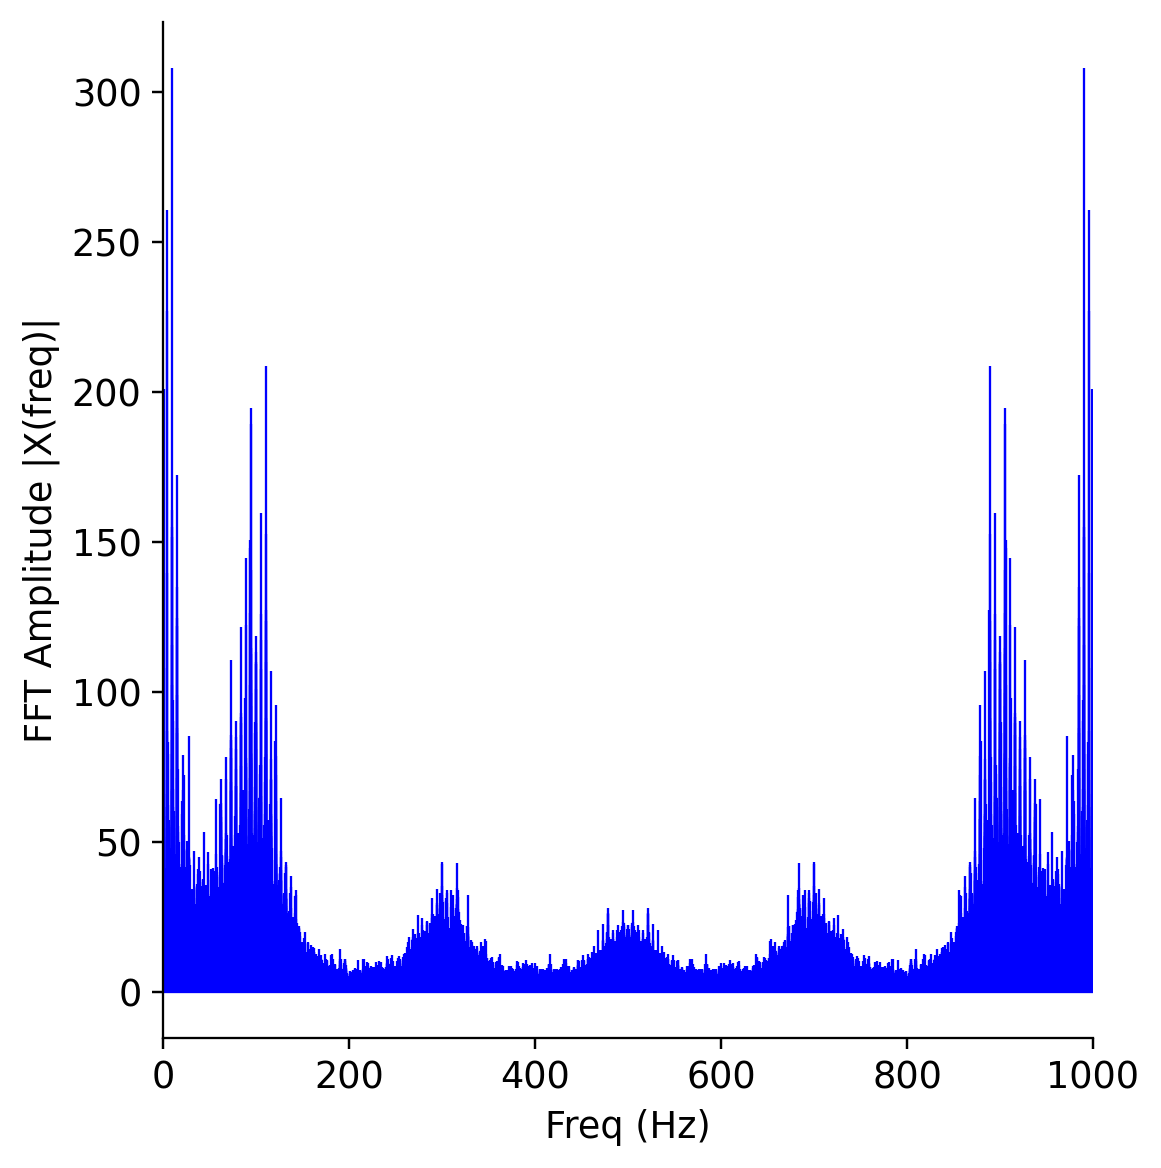

In [67]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.

Mittelwert = np.mean(absolutwerte_nparray)                                       #Mittelwerte aus den Einträgen aus dem Array berechnen                                
a = absolutwerte_nparray - Mittelwert                                            #in Variable a wird ein neues Array gespeichert welches in jedem Eintrag den Mittelwert abzieht (Der Mittelwert aus allen Einträgen des Absolutwerte Arrays)

from numpy.fft import fft, ifft                                                  #importieren der benötigten Funktion und Anpassung an unser Beispiel
X = fft(a)
N = len(X)
n = np.arange(N)
sr = 1000
T = N/sr
freq = n/T 



plt.figure(figsize = (12, 6))                                                   #Plotten der FFT Funktion, festlegen der Größe der Diagramme
plt.subplot(121)
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')                                                          #x-Achse beschriften                                         
plt.ylabel('FFT Amplitude |X(freq)|')                                            #y-Achse beschriften
plt.xlim(0, 1000)                                                                #x-Achsen Limit festlegen

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="image/Mixer.jpg" width="500">

- Beschreibung des Aufbaus: Für meinen Zweiten Versuch verwendete ich meinen Küchenmixer, auf der Oberseite des Mixers befestigte ich den Beschleunigungssensor. 
- Vorgangsbeschreibung: Ich habe die Schwingungen gemessen wenn der Mixer auf voller Stufe aktiviert ist.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [68]:
path_measurement_folder = '/home/pi/lavalrotor_home_experiment/measurement_data/data_20240109_160913_JannikHoffmann_mixer'   #Pfad zum Ordner in dem die Messdaten abgelegt wurden
h5_file_name = 'data_20240109_160913_JannikHoffmann_mixer.h5'                                                                #Name der HDF5 Datei in dem die Messdaten abgelegt wurden

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [69]:
datapath = path_measurement_folder + '/' + h5_file_name                                                        #Vollständiger Pfad zur HDF5 Datei zusammensetzen aus dem Ordner Pfad und dem Namen der HDF5 Datei
with h5py.File(datapath) as l:                                                                                 #HDF5 öffnen als "l" 
    h5_datei = l["RawData"]
    list_x2 = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_x"]                                 #Liste anlegen für die Messwerte der Beschleunigungen in x-Richtung abzuspeichern
    list_y2 = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_y"]                                 #Liste anlegen für die Messwerte der Beschleunigungen in y-Richtung abzuspeichern
    list_z2 = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_z"]                                 #Liste anlegen für die Messwerte der Beschleunigungen in z-Richtung abzuspeichern
    list_time2 = l["RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]                                   #Liste anlegen für die Zeitpunkte der Messungen abzuspeichern
    list_x_Array2=np.array(list_x2)                                                                            #Aus Liste der Messwerte der Beschleunigungen in x-Richtung ein Array erzeugen                                      
    list_y_Array2=np.array(list_y2)                                                                            #Aus Liste der Messwerte der Beschleunigungen in y-Richtung ein Array erzeugen
    list_z_Array2=np.array(list_z2)                                                                            #Aus Liste der Messwerte der Beschleunigungen in z-Richtung ein Array erzeugen                               
    list_time_Array2=np.array(list_time2)                                                                      #Aus Liste der Zeitpunkte der Messungen ein Array erzeugen

#### 2. Betrag der Beschleunigung berechnen


In [70]:
absolutwerte2 = []                                                                                             #Leere Liste erstellen um die Absolutwerte der Beschleunigungen abzuspeichern
i = 0                                                                                                          #Index i als 0 definieren
while i < len(list_x_Array):                                                                                   #While Schleife ist erfüllt solange i kleiner ist als die Länge des Arrays mit den x-Beschleunigungswerten (Alle 3 Arrays sind gleich lang)
    b = list_x_Array2[i]
    c = list_y_Array2[i]
    d = list_z_Array2[i]                                                                                       #Die Einträge i aus den Arrays in den Variablen b,c,d abspeichern
    z = pow((pow(b,2)+ pow(c,2) + pow(d,2)),1/2)                                                               #Betrag der Einträge i aus jedem Array bilden
    absolutwerte2.append(z)                                                                                    #Beträge in der Leeren Liste hinzufügen
    i += 1                                                                                                     #Index bei jedem durchlauf der Schleife um 1+ nach oben zählen
absolutwerte_nparray2 = np.array(absolutwerte2)                                                                #Absolutwerte aus der Liste in ein Absolutwerte Array überführen

#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Zeitlichen Abstände zwischen den Messpunkten in s')

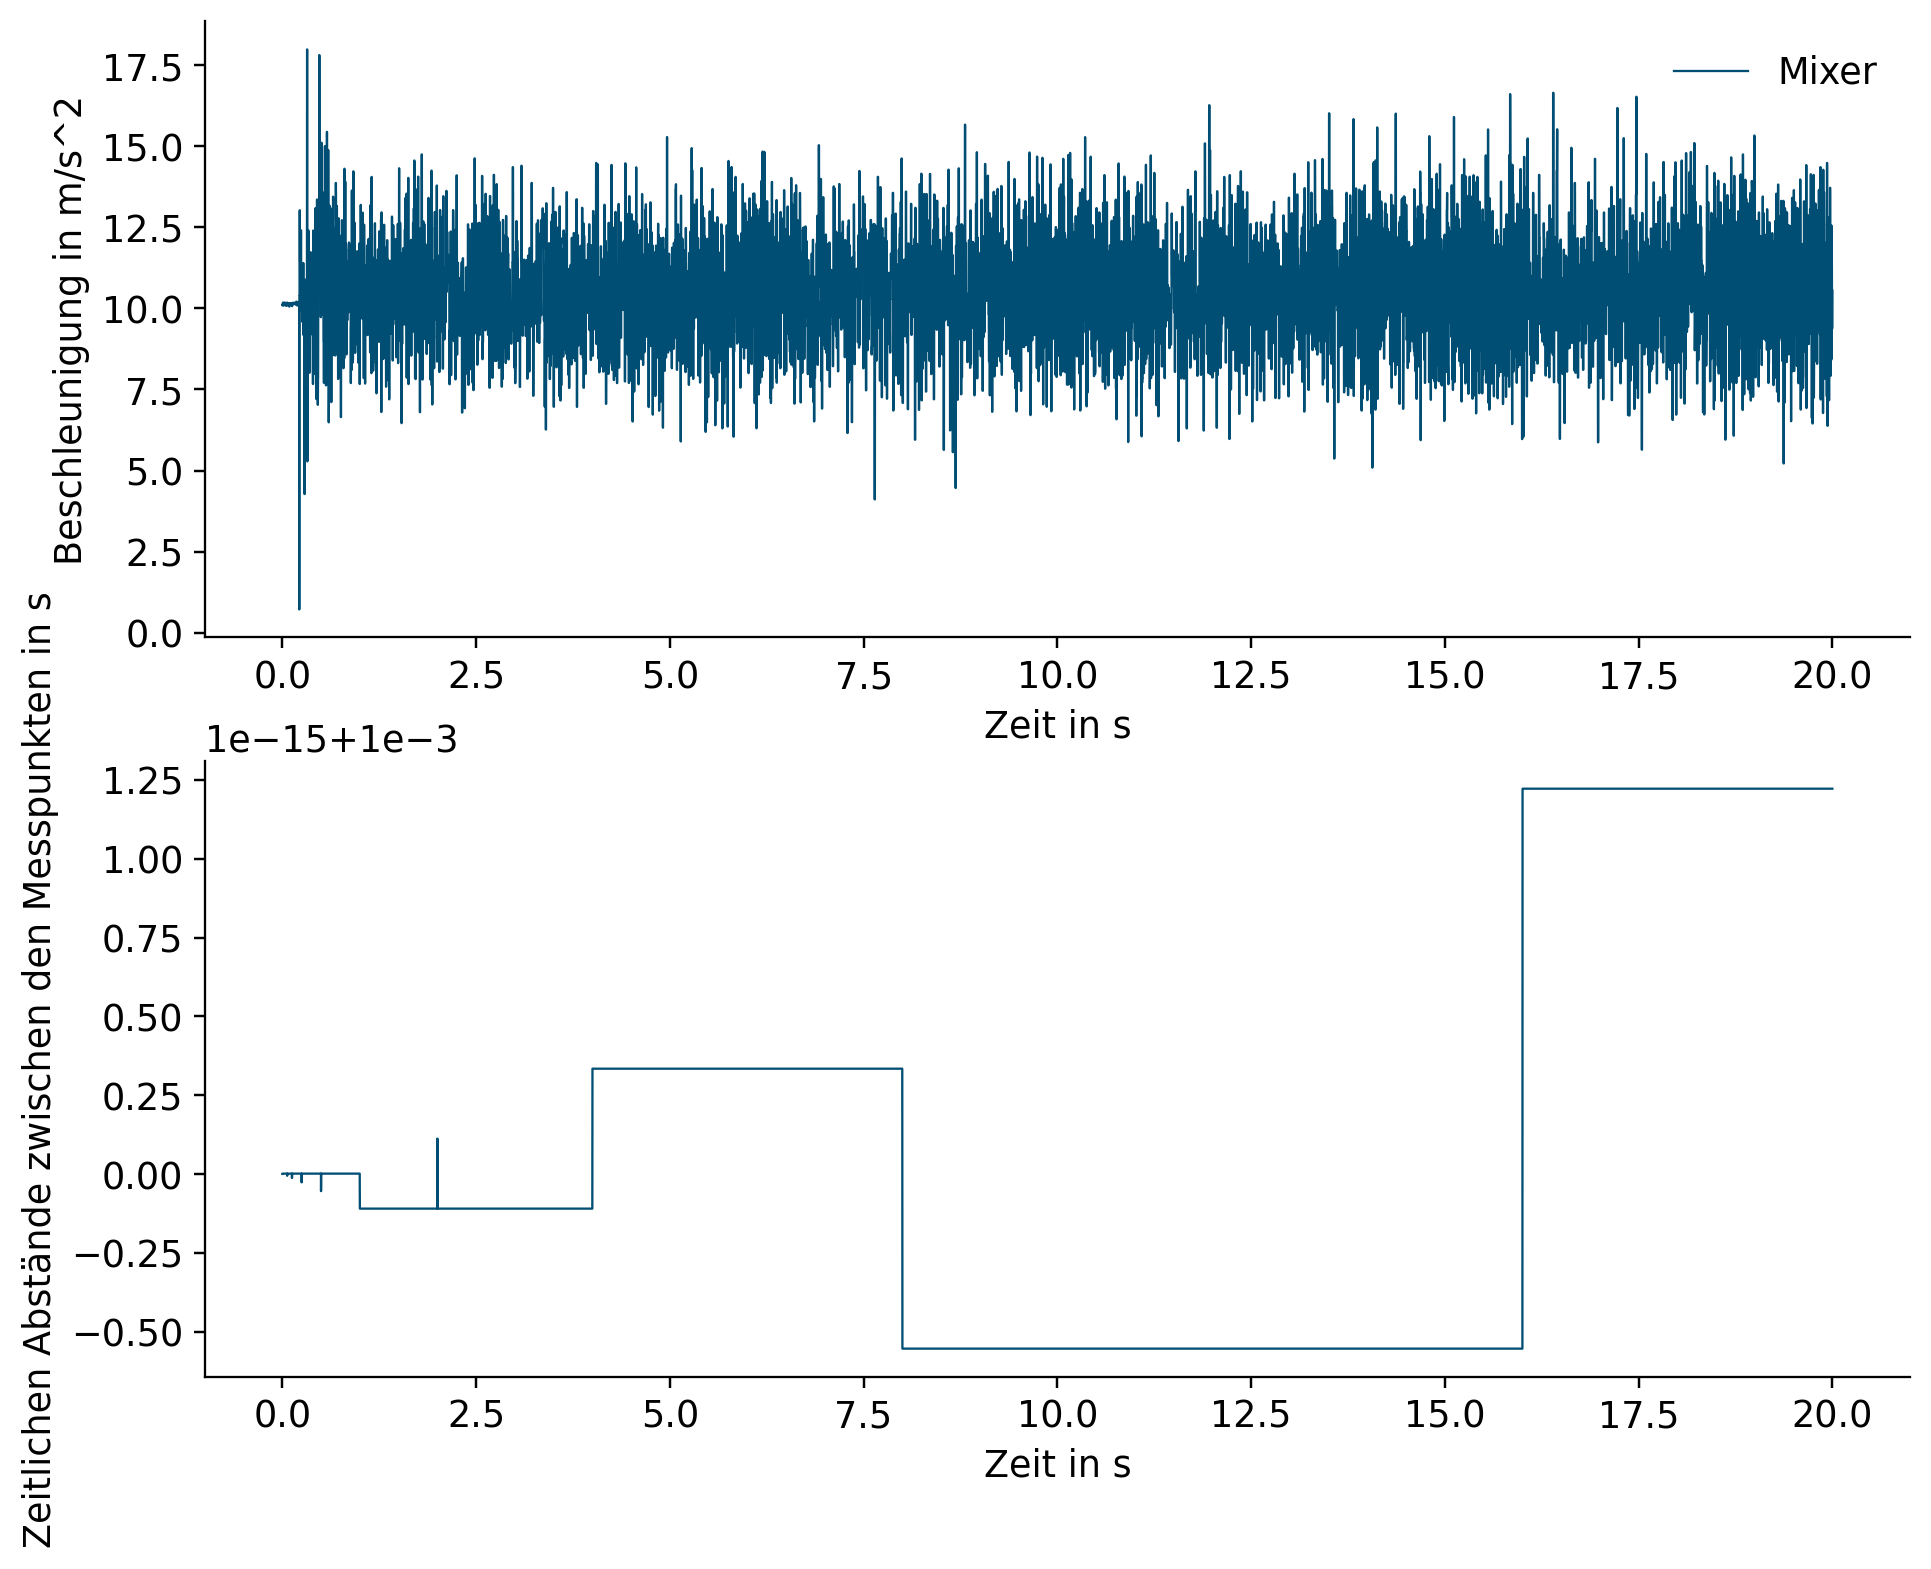

In [71]:

fig, (ax1, ax2)= plt.subplots(2,1,figsize=(10,8 ))

ax1.plot(list_time_Array2, absolutwerte_nparray2, label = 'Mixer')                                             #Array mit den Absolutwerten der Beschleunigung und den Zeiteinträgen plotten        
ax1.set_xlabel('Zeit in s')                                                                                    #x-Achse beschriften                                                    
ax1.set_ylabel('Beschleunigung in m/s^2')                                                                      #y-Achse beschriften                                    
ax1.legend()                                                                                                   #Legende anzeigen lassen                                                                



time_intervall2 = np.diff(list_time_Array2)                                                                    #Array erstellen mit den Abständen der aufeinander folgenden Zeiteinträge
ax2.plot(list_time_Array2[1:], time_intervall2)                                                                #x-Achse beschriften
ax2.set_xlabel('Zeit in s')                                                                                    #Array mit den Abständen der Zeiteinträge und den Zeiteinträgen plotten                                                    
ax2.set_ylabel('Zeitlichen Abstände zwischen den Messpunkten in s')                                            #y-Achse beschriften    

#### 4. Interpolation der Messwerte



In [72]:
#Die Interpolation der Messwerte hat bei meinen Messwerten keinen Nutzen. In meiner geschriebenen Funktion, Zeile 77-85 im Dokument acceleration_measurement.py wird für die Aufzeichnung eine While Schleife verwendet, die 20 Sekunden lang durchläuft. Dabei wird nach jeder Messung 1ms delay ausgeführt und der Index um 0.001 hochgezählt.Der Abstand zwischen den Messungen ist so immer identisch.Somit ist eine Interpolation schlichtweg nicht sinnvoll. Die Genauigkeit der Abstände ist nur durch den Raspberry Pi begrenzt und liegt wie im oberen Graphen zu sehen bei +- 10^-18.

#### 5 & 6. FFT durchführen und graphisch darstellen


(0.0, 1000.0)

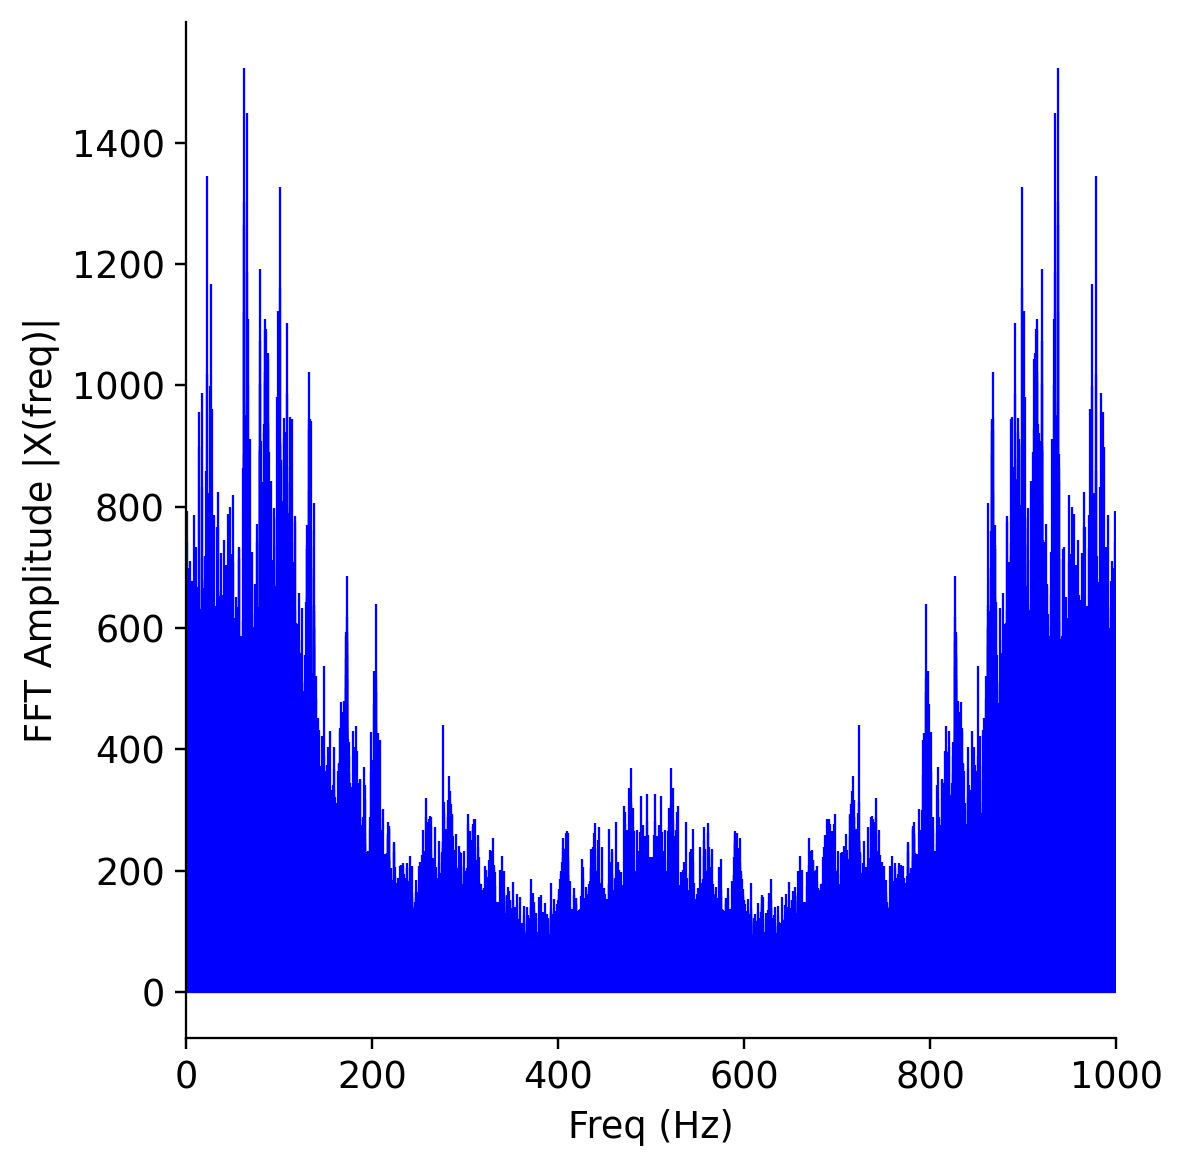

In [73]:
Mittelwert2 = np.mean(absolutwerte_nparray2)                                       #Mittelwerte aus den Einträgen aus dem Array berechnen                                
g = absolutwerte_nparray2 - Mittelwert2                                            #in Variable g wird ein neues Array gespeichert welches in jedem Eintrag den Mittelwert abzieht (Der Mittelwert aus allen Einträgen des Absolutwerte Arrays)

from numpy.fft import fft, ifft                                                    #importieren der benötigten Funktion und Anpassung an unser Beispiel
X = fft(g)
N = len(X)
n = np.arange(N)
sr = 1000
T = N/sr
freq = n/T 



plt.figure(figsize = (12, 6))                                                     #plotten der FFT Funktion, festlegen der Größe der Diagramme
plt.subplot(121)
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')                                                           #x-Achse beschriften                                         
plt.ylabel('FFT Amplitude |X(freq)|')                                             #y-Achse beschriften
plt.xlim(0, 1000)                                                                 #x-Achsen Limit festlegen


## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Ich finde der geschriebene Code und die daraus ermittelnten Versuche lieferten Gute Ergebnisse.Auch unter Berücksichtigung des vereinfachten Versuchsaufbaus funktionierte das wirklich gut. Die Messungen die unter meiner Annahme entstanden sind vielleicht nicht ganz ideal aber zeigen durchaus das die Aufgaben sinnvoll umgesetzt wurden.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Ich fande den Versuch durchaus interessant zu sehen wie deutlich die Schwingungen durch den Beschleunigungssensor sichtbar gemacht werden konnten. Anfangs habe ich erwartet das diese Schwingungen zu finigran sind um diese sinnvoll nutzen zu können.